# NFL Prediction

## Project Scope
Develop a model to predict winners for the NFL 2024 season, using historical betting data going back to 1999.

Models to Train:
Predict if the home team will cover the spread for a particular game.

## Import and Download Libraries

In [1]:
# Install category_encoders
!pip install -q category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install -q nfl_data_py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [3]:
pip install -q pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00


In [4]:
# import data
import nfl_data_py as nfl

# data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
import pytz, datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, KFold


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, accuracy_score, brier_score_loss
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle, joblib
# show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# warnings
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [5]:
# Import data from 1999 (first available) to end of last season
years = range(1999, 2024)
data = nfl.import_schedules(years)
data.tail()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6701,2023_20_TB_DET,2023,DIV,20,2024-01-21,Sunday,15:00,TB,23.0,DET,31.0,Home,8.0,54.0,0.0,2024012100,59502,NaN,202401210det,NaN,401547757,NaN,6,7,225.0,-278.0,6.0,-102.0,-118.0,49.5,-105.0,-115.0,0,dome,fieldturf,NaN,NaN,00-0034855,00-0033106,Baker Mayfield,Jared Goff,Todd Bowles,Dan Campbell,Bill Vinovich,DET00,Ford Field
6702,2023_20_KC_BUF,2023,DIV,20,2024-01-21,Sunday,18:30,KC,27.0,BUF,24.0,Home,-3.0,51.0,0.0,2024012101,59503,NaN,202401210buf,NaN,401547758,NaN,8,6,120.0,-142.0,2.5,-110.0,-110.0,45.5,-108.0,-112.0,0,outdoors,a_turf,25.0,11.0,00-0033873,00-0034857,Patrick Mahomes,Josh Allen,Andy Reid,Sean McDermott,Shawn Hochuli,BUF00,New Era Field
6703,2023_21_KC_BAL,2023,CON,21,2024-01-28,Sunday,15:00,KC,17.0,BAL,10.0,Home,-7.0,27.0,0.0,2024012800,59504,NaN,202401280rav,NaN,401547379,NaN,7,8,180.0,-218.0,4.5,-110.0,-112.0,44.0,-105.0,-115.0,0,outdoors,grass,47.0,7.0,00-0033873,00-0034796,Patrick Mahomes,Lamar Jackson,Andy Reid,John Harbaugh,Shawn Smith,BAL00,M&T Bank Stadium
6704,2023_21_DET_SF,2023,CON,21,2024-01-28,Sunday,18:30,DET,31.0,SF,34.0,Home,3.0,65.0,0.0,2024012801,59505,NaN,202401280sfo,NaN,401547380,NaN,7,8,260.0,-325.0,7.5,-120.0,100.0,52.5,-110.0,-110.0,0,outdoors,grass,69.0,5.0,00-0033106,00-0037834,Jared Goff,Brock Purdy,Dan Campbell,Kyle Shanahan,Clete Blakeman,SFO01,Levi's Stadium
6705,2023_22_SF_KC,2023,SB,22,2024-02-11,Sunday,18:30,SF,22.0,KC,25.0,Neutral,3.0,47.0,1.0,2024021100,59506,NaN,202402110kan,NaN,401547378,NaN,14,14,-120.0,100.0,-1.5,-110.0,-110.0,47.0,-110.0,-110.0,0,dome,grass,NaN,NaN,00-0037834,00-0033873,Brock Purdy,Patrick Mahomes,Kyle Shanahan,Andy Reid,Bill Vinovich,VEG00,Allegiant Stadium


In [6]:
# Spread_line is AWAY SPREAD
data[["away_team", "home_team", "away_score", "home_score", "spread_line", "result"]].tail()

,away_team,home_team,away_score,home_score,spread_line,result
6701,TB,DET,23.0,31.0,6.0,8.0
6702,KC,BUF,27.0,24.0,2.5,-3.0
6703,KC,BAL,17.0,10.0,4.5,-7.0
6704,DET,SF,31.0,34.0,7.5,3.0
6705,SF,KC,22.0,25.0,-1.5,3.0


In [7]:
# Change it to Home spread
data["spread_line"] = data["spread_line"] * -1
data[["away_team", "home_team", "away_score", "home_score", "spread_line", "result"]].tail()

,away_team,home_team,away_score,home_score,spread_line,result
6701,TB,DET,23.0,31.0,-6.0,8.0
6702,KC,BUF,27.0,24.0,-2.5,-3.0
6703,KC,BAL,17.0,10.0,-4.5,-7.0
6704,DET,SF,31.0,34.0,-7.5,3.0
6705,SF,KC,22.0,25.0,1.5,3.0


In [8]:
# Make copy
df = data.copy()

In [9]:
# Shape
print(f"Number of Observations: {df.shape[0]}\nNumber of Columns: {df.shape[1]}")

Number of Observations: 6706
Number of Columns: 46


In [10]:
# Duplicated values
df.duplicated().sum()

0

## Data Preprocessing & Feature Engineering

### Drop Columns
- Drop useless columns

In [11]:
cols_to_drop = ["referee", "roof", "game_id", "gameday", "old_game_id", "gsis", "nfl_detail_id", "pfr", "pff", "espn", "ftn", "away_spread_odds",
                "home_spread_odds", "under_odds", "over_odds", "surface", "away_qb_id", "home_qb_id", "stadium_id", "stadium"]

df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,total_line,div_game,temp,wind,away_qb_name,home_qb_name,away_coach,home_coach
0,1999,REG,1,Sunday,NaN,MIN,17.0,ATL,14.0,Home,-3.0,31.0,0.0,7,7,NaN,NaN,4.0,49.0,0,NaN,NaN,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves
1,1999,REG,1,Sunday,NaN,KC,17.0,CHI,20.0,Home,3.0,37.0,0.0,7,7,NaN,NaN,3.0,38.0,0,80.0,12.0,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron
2,1999,REG,1,Sunday,NaN,PIT,43.0,CLE,0.0,Home,-43.0,43.0,0.0,7,7,NaN,NaN,6.0,37.0,1,78.0,12.0,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer
3,1999,REG,1,Sunday,NaN,OAK,24.0,GB,28.0,Home,4.0,52.0,0.0,7,7,NaN,NaN,-9.0,43.0,0,67.0,10.0,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes
4,1999,REG,1,Sunday,NaN,BUF,14.0,IND,31.0,Home,17.0,45.0,0.0,7,7,NaN,NaN,3.0,45.5,1,NaN,NaN,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora


### Rename Columns

In [12]:
cols_to_rename = {"result": "home_spread_result",
                  "spread_line": "home_spread",
                  "total": "total_result",
                  "location": "neutral_venue",
                  "home_qb_name": "home_qb",
                  "away_qb_name": "away_qb"}

df.rename(columns=cols_to_rename, inplace=True)
df.tail()

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,neutral_venue,home_spread_result,total_result,overtime,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach
6701,2023,DIV,20,Sunday,15:00,TB,23.0,DET,31.0,Home,8.0,54.0,0.0,6,7,225.0,-278.0,-6.0,49.5,0,NaN,NaN,Baker Mayfield,Jared Goff,Todd Bowles,Dan Campbell
6702,2023,DIV,20,Sunday,18:30,KC,27.0,BUF,24.0,Home,-3.0,51.0,0.0,8,6,120.0,-142.0,-2.5,45.5,0,25.0,11.0,Patrick Mahomes,Josh Allen,Andy Reid,Sean McDermott
6703,2023,CON,21,Sunday,15:00,KC,17.0,BAL,10.0,Home,-7.0,27.0,0.0,7,8,180.0,-218.0,-4.5,44.0,0,47.0,7.0,Patrick Mahomes,Lamar Jackson,Andy Reid,John Harbaugh
6704,2023,CON,21,Sunday,18:30,DET,31.0,SF,34.0,Home,3.0,65.0,0.0,7,8,260.0,-325.0,-7.5,52.5,0,69.0,5.0,Jared Goff,Brock Purdy,Dan Campbell,Kyle Shanahan
6705,2023,SB,22,Sunday,18:30,SF,22.0,KC,25.0,Neutral,3.0,47.0,1.0,14,14,-120.0,100.0,1.5,47.0,0,NaN,NaN,Brock Purdy,Patrick Mahomes,Kyle Shanahan,Andy Reid


### Missing Values

In [13]:
columns_with_missing_values = df.columns[df.isnull().any()]
missing_value_counts = df[columns_with_missing_values].isnull().sum()

for column, count in missing_value_counts.items():
      print(f"'{column}' has {count} missing values.")

'gametime' has 259 missing values.
'away_moneyline' has 1981 missing values.
'home_moneyline' has 1981 missing values.
'temp' has 1872 missing values.
'wind' has 1872 missing values.


- gametime: most frequent value
- away_moneyline: average/median value for team
- home_moneyline: average/median value for team
- surface: most frequent value
- temp: average value for stadium
- wind: average value for stadium
- away_qb_name: most recent value for team
- home_qb_name: most recent value for team
- referee: most frequent value

#### Most Frequent Value
- Gametime
- Referee

In [14]:
# Impute these columns with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
cols_to_impute = ['gametime']

# Fit and transform the imputer on the DataFrame
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Sum of missing values
missing_value_counts = df[cols_to_impute].isna().sum().sum()
print(f"Number of missing values in 'gametime' and 'referee' is: {missing_value_counts}")

Number of missing values in 'gametime' and 'referee' is: 0


#### Average Value for Stadium
- Temperature
- Wind


In [15]:
# Step 1: Calculate the average "temp" and "wind" values for each "team"
average_weather_by_team = df.groupby('home_team')[['temp', 'wind']].mean()

# Step 2: Impute missing values using the average values for each "team"
imputer = SimpleImputer(strategy='mean')  # Use mean strategy for any remaining missing values

# Impute missing values based on the average values for each "team"
for team, avg_values in average_weather_by_team.iterrows():
    df.loc[df['home_team'] == team, ['temp', 'wind']] = df.loc[df['home_team'] == team, ['temp', 'wind']].fillna(avg_values)

# For any remaining missing values (where team information is not available),
# impute using the overall mean temperature and wind speed
df[['temp', 'wind']] = imputer.fit_transform(df[['temp', 'wind']])

# Define cols_to_impute
cols_to_impute = ['temp', 'wind']

# Calculate the number of missing values in these columns
missing_value_counts = df[cols_to_impute].isna().sum().sum()
print(f"Number of missing values in 'wind' and 'temperature' is: {missing_value_counts}")

Number of missing values in 'wind' and 'temperature' is: 0


#### Average Value for Team
- Away Moneyline
- Home Moneyline

##### Home

In [16]:
# Group the original DataFrame by the "home_team" column
grouped_df = df.groupby("home_team")

# Iterate over each group (team) and get the mean of "home_moneyline" for non-null values
team_moneyline_means = {}
for team, group in grouped_df:
    mean_moneyline = group["home_moneyline"].mean()
    df.loc[(df["home_team"] == team) & (df["home_moneyline"].isnull()), "home_moneyline"] = mean_moneyline

# Check the number of missing values in the "home_moneyline" column after replacement
missing_values_count = df["home_moneyline"].isna().sum()
print("Number of missing values in 'home_moneyline' column:", missing_values_count)

Number of missing values in 'home_moneyline' column: 0


##### Away

In [17]:
# Group the original DataFrame by the "home_team" column
grouped_df = df.groupby("away_team")

# Iterate over each group (team) and get the mean of "home_moneyline" for non-null values
team_moneyline_means = {}
for team, group in grouped_df:
    mean_moneyline = group["away_moneyline"].mean()
    df.loc[(df["away_team"] == team) & (df["away_moneyline"].isnull()), "away_moneyline"] = mean_moneyline

# Check the number of missing values in the "home_moneyline" column after replacement
missing_values_count = df["away_moneyline"].isna().sum()
print("Number of missing values in 'away_moneyline' column:", missing_values_count)

Number of missing values in 'away_moneyline' column: 0


#### Most Recent Value for Team
- Home QB
- Away QB

In [18]:
# Sort the DataFrame by season in ascending order
df.sort_values(by='season', inplace=True)

# Forward fill missing values based on the most recent observation of "home_team" and "away_team"
df['home_qb'] = df.groupby('home_team')['home_qb'].ffill()
df['away_qb'] = df.groupby('away_team')['away_qb'].ffill()

# Count the number of missing values in the specified columns
missing_values_count = df[["home_qb", "away_qb"]].isna().sum()

# Print the count of missing values
print(f"Number of missing values in 'home_qb_name' and 'away_qb_name' columns:\n{missing_values_count}")

Number of missing values in 'home_qb_name' and 'away_qb_name' columns:
home_qb    0
away_qb    0
dtype: int64


#### Double Check

In [19]:
total_isna = df.isna().sum().sum()
print(f"Total Missing Values: {total_isna}")

Total Missing Values: 0


In [20]:
# show sample
df.head()

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,neutral_venue,home_spread_result,total_result,overtime,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach
0,1999,REG,1,Sunday,13:00,MIN,17.0,ATL,14.0,Home,-3.0,31.0,0.0,7,7,80.472973,-128.204082,4.0,49.0,0,61.000000,10.500000,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves
165,1999,REG,12,Sunday,13:00,SD,27.0,MIN,35.0,Home,8.0,62.0,0.0,7,14,22.000000,-147.589041,-13.5,43.5,0,41.315789,7.473684,Jim Harbaugh,Jeff George,Mike Riley,Dennis Green
166,1999,REG,12,Sunday,13:00,ARI,34.0,NYG,24.0,Home,-10.0,58.0,0.0,7,7,153.714286,-64.542254,-4.5,34.5,1,48.000000,16.000000,Dave Brown,Kerry Collins,Vince Tobin,Jim Fassel
167,1999,REG,12,Sunday,13:00,KC,37.0,OAK,34.0,Home,-3.0,71.0,0.0,7,6,41.724832,64.564815,-3.5,37.0,1,55.000000,5.000000,Elvis Grbac,Rich Gannon,Gunther Cunningham,Jon Gruden
168,1999,REG,12,Sunday,13:00,CIN,27.0,PIT,20.0,Home,-7.0,47.0,0.0,7,7,98.150685,-228.384106,-11.0,36.0,1,46.000000,0.000000,Jeff Blake,Kordell Stewart,Bruce Coslet,Bill Cowher


### Change Datatypes

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6706 entries, 0 to 6705
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              6706 non-null   int64  
 1   game_type           6706 non-null   object 
 2   week                6706 non-null   int64  
 3   weekday             6706 non-null   object 
 4   gametime            6706 non-null   object 
 5   away_team           6706 non-null   object 
 6   away_score          6706 non-null   float64
 7   home_team           6706 non-null   object 
 8   home_score          6706 non-null   float64
 9   neutral_venue       6706 non-null   object 
 10  home_spread_result  6706 non-null   float64
 11  total_result        6706 non-null   float64
 12  overtime            6706 non-null   float64
 13  away_rest           6706 non-null   int64  
 14  home_rest           6706 non-null   int64  
 15  away_moneyline      6706 non-null   float64
 16  home_m

#### Floats to Ints

In [22]:
# change all floats to ints
cols_to_int= df.select_dtypes(include=['float64'])

for column in cols_to_int:
    df[column] = df[column].astype('int64')

#### Objects to Categories

In [23]:
# change all objects to categories
cols_to_cat= df.select_dtypes(include=['object'])

for column in cols_to_cat:
    df[column] = df[column].astype('category')

In [24]:
# Convert "gametime" column to datetime format and extract the hour
pd.to_datetime(df['gametime'], format='%H:%M').dt.hour.value_counts()

,gametime
13,3661
16,1739
20,997
9,122
18,51
12,36
15,32
19,29
17,14
22,14


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6706 entries, 0 to 6705
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   season              6706 non-null   int64   
 1   game_type           6706 non-null   category
 2   week                6706 non-null   int64   
 3   weekday             6706 non-null   category
 4   gametime            6706 non-null   category
 5   away_team           6706 non-null   category
 6   away_score          6706 non-null   int64   
 7   home_team           6706 non-null   category
 8   home_score          6706 non-null   int64   
 9   neutral_venue       6706 non-null   category
 10  home_spread_result  6706 non-null   int64   
 11  total_result        6706 non-null   int64   
 12  overtime            6706 non-null   int64   
 13  away_rest           6706 non-null   int64   
 14  home_rest           6706 non-null   int64   
 15  away_moneyline      6706 non-null   in

### Create Home Cover column


In [26]:
# home spread cover
temp_spread = (df["home_score"] - df["away_score"]) + df["home_spread"]
df["home_cover_spread"] = np.where(temp_spread > 0, 1, 0)

df["home_cover_spread"].value_counts(1)

,home_cover_spread
0,0.530719
1,0.469281


In [27]:
df.sort_index(inplace=True)
df.head()

,season,game_type,week,weekday,gametime,away_team,away_score,home_team,home_score,neutral_venue,home_spread_result,total_result,overtime,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach,home_cover_spread
0,1999,REG,1,Sunday,13:00,MIN,17,ATL,14,Home,-3,31,0,7,7,80,-128,4,49,0,61,10,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,1
1,1999,REG,1,Sunday,13:00,KC,17,CHI,20,Home,3,37,0,7,7,41,-75,3,38,0,80,12,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,1
2,1999,REG,1,Sunday,13:00,PIT,43,CLE,0,Home,-43,43,0,7,7,-50,-6,6,37,1,78,12,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,0
3,1999,REG,1,Sunday,13:00,OAK,24,GB,28,Home,4,52,0,7,7,288,-284,-9,43,0,67,10,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,0
4,1999,REG,1,Sunday,13:00,BUF,14,IND,31,Home,17,45,0,7,7,106,-181,3,45,1,60,6,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,1


### Drop Result Columns

In [28]:
# drop non predictive columns
cols = ["home_score", "away_score", "home_spread_result", "total_result", "overtime"]
df.drop(columns=cols, axis=1, inplace=True)
df.head()

,season,game_type,week,weekday,gametime,away_team,home_team,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach,home_cover_spread
0,1999,REG,1,Sunday,13:00,MIN,ATL,Home,7,7,80,-128,4,49,0,61,10,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,1
1,1999,REG,1,Sunday,13:00,KC,CHI,Home,7,7,41,-75,3,38,0,80,12,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,1
2,1999,REG,1,Sunday,13:00,PIT,CLE,Home,7,7,-50,-6,6,37,1,78,12,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,0
3,1999,REG,1,Sunday,13:00,OAK,GB,Home,7,7,288,-284,-9,43,0,67,10,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,0
4,1999,REG,1,Sunday,13:00,BUF,IND,Home,7,7,106,-181,3,45,1,60,6,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,1


### Remove Non-Existing Teams

In [29]:
# unique teams
print(df["home_team"].unique().tolist())

['ATL', 'CHI', 'CLE', 'GB', 'IND', 'JAX', 'NO', 'NYJ', 'PHI', 'SEA', 'STL', 'TB', 'TEN', 'WAS', 'DEN', 'BAL', 'BUF', 'CAR', 'CIN', 'DET', 'KC', 'MIA', 'MIN', 'NE', 'NYG', 'SF', 'DAL', 'OAK', 'PIT', 'SD', 'ARI', 'HOU', 'LA', 'LAC', 'LV']


- OAK
- SD
- STL/LA

In [30]:
# list of teams with old and new names
non_exist_teams = {
    "OAK": "LV",
    "SD": "LAC",
    "STL": "LAR",
    "LA": "LAR"
}

# replace values
df.replace(non_exist_teams, inplace=True)

# declare again values of unique teams
num_home_teams = len(np.unique(df["home_team"]))
num_away_teams = len(np.unique(df["away_team"]))

print(f"There are {num_home_teams} home teams and {num_away_teams} away teams in our dataset.")

There are 32 home teams and 32 away teams in our dataset.


### Treat QB and HC Values
- Keep only values that appear more than 16 games (one season)

In [31]:
# value counts
for column in df.columns:
    if df[column].dtype == 'category':
      len_col = len(df[column].value_counts())
      print(f"Value counts for column '{column}': {len_col}")
      print()

Value counts for column 'game_type': 5

Value counts for column 'weekday': 7

Value counts for column 'gametime': 55

Value counts for column 'away_team': 32

Value counts for column 'home_team': 32

Value counts for column 'neutral_venue': 2

Value counts for column 'away_qb': 318

Value counts for column 'home_qb': 303

Value counts for column 'away_coach': 164

Value counts for column 'home_coach': 164



In [32]:
# Declare variables
n_games = 16
away_qb_counts = df['away_qb'].value_counts()
home_qb_counts = df['home_qb'].value_counts()

# Change QBs with less than X games to "other" for away_qb
df['away_qb'] = df['away_qb'].astype(str)
qb_to_other_away = away_qb_counts[away_qb_counts < n_games].index.tolist()
df.loc[df['away_qb'].isin(qb_to_other_away), 'away_qb'] = 'other'

# Change QBs with less than X games to "other" for home_qb
df['home_qb'] = df['home_qb'].astype(str)
qb_to_other_home = home_qb_counts[home_qb_counts < n_games].index.tolist()
df.loc[df['home_qb'].isin(qb_to_other_home), 'home_qb'] = 'other'

# Count
away_qb_count = len(df['away_qb'].unique())
home_qb_count = len(df['home_qb'].unique())
print(f"Number of Unique Away QBs: {away_qb_count}\nNumber of Unique Home QBs: {home_qb_count}")

Number of Unique Away QBs: 121
Number of Unique Home QBs: 119


In [33]:
# Declare variables
n_games = 16

away_coach_counts = df['away_coach'].value_counts()
home_coach_counts = df['home_coach'].value_counts()

# Change coaches with less than 16 games to "other" for away_coach
df['away_coach'] = df['away_coach'].astype(str)
coach_to_other_away = away_coach_counts[away_coach_counts < n_games].index.tolist()
df.loc[df['away_coach'].isin(coach_to_other_away), 'away_coach'] = 'other'

# Change coaches with less than 16 games to "other" for home_coach
df['home_coach'] = df['home_coach'].astype(str)
coach_to_other_home = home_coach_counts[home_coach_counts < n_games].index.tolist()
df.loc[df['home_coach'].isin(coach_to_other_home), 'home_coach'] = 'other'

# Count unique coaches
away_coach_count = len(df['away_coach'].unique())
home_coach_count = len(df['home_coach'].unique())
print(f"Number of Unique Away Coaches: {away_coach_count}\nNumber of Unique Home Coaches: {home_coach_count}")

Number of Unique Away Coaches: 128
Number of Unique Home Coaches: 127


- Gametype: regular or playoffs
- Weekday: sunday, monday, thursday, saturday, other
- Gametime: round by hour

Target Encoder ("home_win")
- Home & Away Team
- Home & Away QB Name
- Home & Away QB Coach
- Referee
- Stadium

### One Hot Encoding
- Game type
- Weekday
- Gametime
- Neutral Venue

#### Game Type

In [34]:
game_types = ["WC", "DIV", "CON", "SB"]
df["game_type"] = df["game_type"].replace({type: "Playoffs" for type in game_types})
df["game_type"].value_counts()

,game_type
REG,6423
Playoffs,283


In [35]:
df["game_type"].replace({"REG": 0, "Playoffs": 1}, inplace=True)
df.rename(columns={"game_type": "playoffs"}, inplace=True)
df["playoffs"].value_counts()

,playoffs
0,6423
1,283


#### Weekday

In [36]:
# Replace uncommon playing days with "Other"
days = ["Saturday", "Friday", "Tuesday", "Wednesday"]
df["weekday"] = df["weekday"].replace({day: "Other" for day in days})
df["weekday"].value_counts()

,weekday
Sunday,5732
Monday,436
Thursday,289
Other,249


In [37]:
# Specify the columns to be one-hot encoded
ohe_cols = ["weekday"]

# Perform one-hot encoding
df = pd.get_dummies(df, columns=ohe_cols, drop_first=True)

# Replace Bools with Binary code
df.replace({True: 1, False: 0}, inplace=True)

# Display the first few rows of the encoded DataFrame
df.tail()

,season,playoffs,week,gametime,away_team,home_team,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach,home_cover_spread,weekday_Other,weekday_Sunday,weekday_Thursday
6701,2023,1,20,15:00,TB,DET,Home,6,7,225,-278,-6,49,0,58,8,Baker Mayfield,Jared Goff,Todd Bowles,Dan Campbell,1,0,1,0
6702,2023,1,20,18:30,KC,BUF,Home,8,6,120,-142,-2,45,0,25,11,Patrick Mahomes,Josh Allen,Andy Reid,Sean McDermott,0,0,1,0
6703,2023,1,21,15:00,KC,BAL,Home,7,8,180,-218,-4,44,0,47,7,Patrick Mahomes,Lamar Jackson,Andy Reid,John Harbaugh,0,0,1,0
6704,2023,1,21,18:30,DET,SF,Home,7,8,260,-325,-7,52,0,69,5,Jared Goff,other,Dan Campbell,Kyle Shanahan,0,0,1,0
6705,2023,1,22,18:30,SF,KC,Neutral,14,14,-120,100,1,47,0,51,9,other,Patrick Mahomes,Kyle Shanahan,Andy Reid,1,0,1,0


#### Gametime

In [38]:
# Convert "gametime" column to string if not already
df["gametime"] = df["gametime"].astype(str)

# Remove the second part of time (minutes), to reduce category
df["gametime"] = df["gametime"].str.split(':').str[0]

# Change to int type
df["gametime"] = df["gametime"].astype(int)

# Group gametime into categories
df["gametime"] = df["gametime"].apply(
    lambda x: 13 if x <= 13 else (16 if 13 < x <= 17 else 20)
)

# Show sample of the modified "gametime" column
df["gametime"].value_counts(1)

,gametime
13,0.569490
16,0.266478
20,0.164032


#### Neutral Venue

In [39]:
# Replace "Home" with 0 and other values with 1 in the "neutral_venue" column
df["neutral_venue"] = df["neutral_venue"].replace({"Home": 0, "Neutral": 1})
df["neutral_venue"].value_counts(1)

,neutral_venue
0,0.98822
1,0.01178


In [40]:
df.head()

,season,playoffs,week,gametime,away_team,home_team,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach,home_cover_spread,weekday_Other,weekday_Sunday,weekday_Thursday
0,1999,0,1,13,MIN,ATL,0,7,7,80,-128,4,49,0,61,10,other,Chris Chandler,Dennis Green,Dan Reeves,1,0,1,0
1,1999,0,1,13,KC,CHI,0,7,7,41,-75,3,38,0,80,12,Elvis Grbac,other,Gunther Cunningham,Dick Jauron,1,0,1,0
2,1999,0,1,13,PIT,CLE,0,7,7,-50,-6,6,37,1,78,12,Kordell Stewart,other,Bill Cowher,Chris Palmer,0,0,1,0
3,1999,0,1,13,LV,GB,0,7,7,288,-284,-9,43,0,67,10,Rich Gannon,Brett Favre,Jon Gruden,other,0,0,1,0
4,1999,0,1,13,BUF,IND,0,7,7,106,-181,3,45,1,60,6,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,1,0,1,0


### Target Encoder

In [41]:
# save copy before target encoding, for later use
df_before_te = df.copy()
df_before_te.head()

,season,playoffs,week,gametime,away_team,home_team,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,away_qb,home_qb,away_coach,home_coach,home_cover_spread,weekday_Other,weekday_Sunday,weekday_Thursday
0,1999,0,1,13,MIN,ATL,0,7,7,80,-128,4,49,0,61,10,other,Chris Chandler,Dennis Green,Dan Reeves,1,0,1,0
1,1999,0,1,13,KC,CHI,0,7,7,41,-75,3,38,0,80,12,Elvis Grbac,other,Gunther Cunningham,Dick Jauron,1,0,1,0
2,1999,0,1,13,PIT,CLE,0,7,7,-50,-6,6,37,1,78,12,Kordell Stewart,other,Bill Cowher,Chris Palmer,0,0,1,0
3,1999,0,1,13,LV,GB,0,7,7,288,-284,-9,43,0,67,10,Rich Gannon,Brett Favre,Jon Gruden,other,0,0,1,0
4,1999,0,1,13,BUF,IND,0,7,7,106,-181,3,45,1,60,6,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,1,0,1,0


In [42]:
# Create copy of data
pre_targetencoder_data = df.copy()

In [43]:
# Specify the columns to be encoded
te_cols = ["home_team", "away_team", "home_qb", "away_qb", "home_coach", "away_coach"]

# Ensure that the columns to be encoded are not categorical
for col in te_cols:
    df[col] = df[col].astype(str)

# Initialize the TargetEncoder
target_encoder = ce.TargetEncoder(cols=te_cols)

# Fit the encoder to the data
target_encoder.fit(df[te_cols], df["home_cover_spread"])

# Transform the data
df_encoded = target_encoder.transform(df[te_cols])

# Add the encoded columns to the original DataFrame
te_homespread_df = pd.concat([df, df_encoded.add_suffix('_encoded')], axis=1)

# Drop normal columns
te_homespread_df.drop(columns=te_cols, axis=1, inplace=True)

te_homespread_df.tail()

,season,playoffs,week,gametime,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,home_cover_spread,weekday_Other,weekday_Sunday,weekday_Thursday,home_team_encoded,away_team_encoded,home_qb_encoded,away_qb_encoded,home_coach_encoded,away_coach_encoded
6701,2023,1,20,16,0,6,7,225,-278,-6,49,0,58,8,1,0,1,0,0.502463,0.480952,0.530498,0.488097,0.601172,0.498797
6702,2023,1,20,20,0,8,6,120,-142,-2,45,0,25,11,0,0,1,0,0.488038,0.435407,0.499008,0.380628,0.492055,0.388889
6703,2023,1,21,16,0,7,8,180,-218,-4,44,0,47,7,0,0,1,0,0.492891,0.435407,0.423222,0.380628,0.463235,0.388889
6704,2023,1,21,20,0,7,8,260,-325,-7,52,0,69,5,0,0,1,0,0.476415,0.502415,0.423077,0.410805,0.460437,0.378443
6705,2023,1,22,20,1,14,14,-120,100,1,47,0,51,9,1,0,1,0,0.477273,0.476636,0.491436,0.515723,0.471616,0.407014


### Train-Test Split

In [44]:
# Save columns for later
df_columns = df.columns
# df_columns = df.columns
print(df_columns)

Index(['season', 'playoffs', 'week', 'gametime', 'away_team', 'home_team',
       'neutral_venue', 'away_rest', 'home_rest', 'away_moneyline',
       'home_moneyline', 'home_spread', 'total_line', 'div_game', 'temp',
       'wind', 'away_qb', 'home_qb', 'away_coach', 'home_coach',
       'home_cover_spread', 'weekday_Other', 'weekday_Sunday',
       'weekday_Thursday'],
      dtype='object')


In [45]:
te_homespread_df.head()

,season,playoffs,week,gametime,neutral_venue,away_rest,home_rest,away_moneyline,home_moneyline,home_spread,total_line,div_game,temp,wind,home_cover_spread,weekday_Other,weekday_Sunday,weekday_Thursday,home_team_encoded,away_team_encoded,home_qb_encoded,away_qb_encoded,home_coach_encoded,away_coach_encoded
0,1999,0,1,13,0,7,7,80,-128,4,49,0,61,10,1,0,1,0,0.437500,0.502370,0.477433,0.515723,0.373326,0.604789
1,1999,0,1,13,0,7,7,41,-75,3,38,0,80,12,1,0,1,0,0.449761,0.435407,0.423077,0.537563,0.506813,0.531773
2,1999,0,1,13,0,7,7,-50,-6,6,37,1,78,12,0,0,1,0,0.435644,0.443925,0.423077,0.416551,0.431445,0.353891
3,1999,0,1,13,0,7,7,288,-284,-9,43,0,67,10,0,0,1,0,0.543779,0.482927,0.480389,0.440241,0.419476,0.527769
4,1999,0,1,13,0,7,7,106,-181,3,45,1,60,6,1,0,1,0,0.497674,0.463415,0.500000,0.447909,0.482464,0.536646


In [46]:
# te_homespread_df = te_homespread_df[["season", "home_spread", "home_team_encoded","away_team_encoded", "home_qb_encoded",
#                                      "away_qb_encoded", "home_coach_encoded", "away_coach_encoded", "home_cover_spread",
#                                      ]]
#                                     #  "away_moneyline", "home_moneyline", "week", "gametime", "total_line",
# te_homespread_df.sample(5)

In [47]:
# Train - 70%
# Validation - 15%
# Test - 15%

# Declare X and y
X = te_homespread_df.drop(columns=["home_cover_spread"])
y = te_homespread_df["home_cover_spread"]

# First, split into training (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X, y, test_size=0.3,shuffle=True, random_state=42
)

# Then, split the remaining 30% into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, shuffle=True, random_state=42
)

# Print the shapes of train, validation, and test sets
print(f"X_train shape: {X_train.shape}")
print("-" * 25)
print(f"X_val shape: {X_val.shape}")
print("-" * 25)
print(f"X_test shape: {X_test.shape}")
print("-" * 25)
print(f"y_train shape: {y_train.shape}")
print("-" * 25)
print(f"y_val shape: {y_val.shape}")
print("-" * 25)
print(f"y_test shape: {y_test.shape}")

# Turn data into arrays
X_train_array = X_train.values
X_val_array = X_val.values
X_test_array = X_test.values

X_train shape: (4694, 23)
-------------------------
X_val shape: (1006, 23)
-------------------------
X_test shape: (1006, 23)
-------------------------
y_train shape: (4694,)
-------------------------
y_val shape: (1006,)
-------------------------
y_test shape: (1006,)


### Standardization

In [48]:
# Initialize the StandardScaler
scaler_homespread = StandardScaler()

# Fit and transform the numerical columns in the training set and test set
X_train_scaled = scaler_homespread.fit_transform(X_train_array)
X_val_scaled = scaler_homespread.fit_transform(X_val_array)
X_test_scaled = scaler_homespread.transform(X_test_array)

# Show sample of X_train
X_train_scaled[0]

array([ 1.50148019, -0.21640976, -0.30352715, -0.76873439, -0.10787924,
       -0.2531439 , -0.24835508,  0.37078228, -0.25658234, -0.30807212,
       -0.45898957,  1.27717106,  0.15709611,  0.3783705 , -0.20198571,
        0.41265206, -0.20763215, -0.9825521 , -0.16025965, -0.7456171 ,
        0.8006596 , -1.78511631,  1.04911123])

In [49]:
# Save the scaler to a file in Google Drive
scaler_filename = '/content/drive/MyDrive/NFLPred/Scalers/scaler_homespread.pkl'
joblib.dump(scaler_homespread, scaler_filename)

['/content/drive/MyDrive/NFLPred/Scalers/scaler_homespread.pkl']

## Modeling
Metric of Interest:

### Baseline Models
- Linear Regression
- Neural Network

In [50]:
# function to train models and return metrics
def train_model(model, X_train, y_train, X_test, y_test):
  """
  model: model to train
  X_train: X_train scaled
  y_train: y_train
  X_test: X_test scaled
  y_test: y_test
  """
  # Train Model
  model.fit(X_train, y_train)

  # Make Predictions
  y_pred = model.predict(X_val)

  # Make Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')

  print(" ")

  # Compute ROC curve and ROC area
  y_probs = model.predict_proba(X_test_scaled)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_probs)
  roc_auc = roc_auc_score(y_test, y_probs)

  # Show metrics
  report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(report)

  num_folds = 5
  kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
  brier_score = brier_score_loss(y_val, y_probs)

  print(f'Brier Score: {brier_score:.2f}')
  print("Cross-Validation Scores:", cv_scores)
  print("Mean CV Accuracy:", np.mean(cv_scores).round(4))
  print("Standard Deviation of CV Accuracy:", np.std(cv_scores).round(4))

#### Logistic Regression

 
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.00      0.01       526
           1       0.48      1.00      0.65       480

    accuracy                           0.48      1006
   macro avg       0.57      0.50      0.33      1006
weighted avg       0.58      0.48      0.31      1006

Brier Score: 0.26
Cross-Validation Scores: [0.61874334 0.59744409 0.57933972 0.59637913 0.6119403 ]
Mean CV Accuracy: 0.6008
Standard Deviation of CV Accuracy: 0.0137


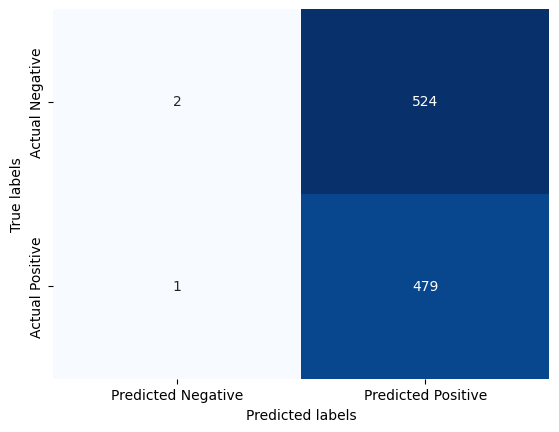

In [51]:
lr = LogisticRegression(random_state=42)
train_model(lr, X_train_scaled, y_train, X_val_scaled, y_val)

##### Feature Importances

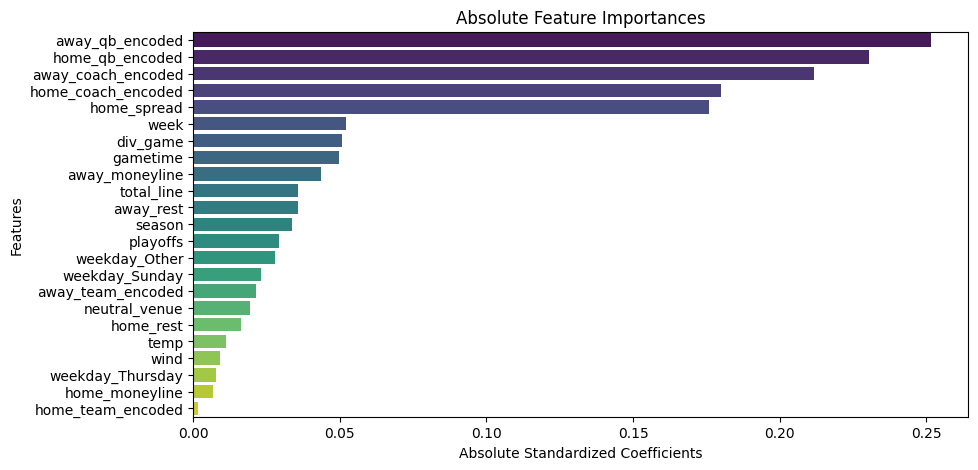

In [52]:
coefficients = lr.coef_[0]
feature_names = X.columns
std_coefficients = coefficients / np.std(X_train_scaled, axis=0)

# Create a dictionary mapping feature names to standardized coefficients
feature_importances = dict(zip(feature_names, std_coefficients))

# Sort feature importances by absolute value
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract features and importances from the sorted list
features = [item[0] for item in sorted_feature_importances]
importances = [abs(item[1]) for item in sorted_feature_importances]

# Create a horizontal bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.xlabel('Absolute Standardized Coefficients')
plt.ylabel('Features')
plt.title('Absolute Feature Importances')
plt.show()

Insights
- Logistic Regression performs better than XGB Classifier
- Most important attributes:

    - Encoded home and away values (Coaches, QBs)
    - Home Spread
    - Week
    - Divisional Game
    - Game time

#### Neural Networks

In [53]:
# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=15, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5553 - loss: 0.6931 - val_accuracy: 0.5835 - val_loss: 0.6746
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6154 - loss: 0.6611 - val_accuracy: 0.5974 - val_loss: 0.6714
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6244 - loss: 0.6548 - val_accuracy: 0.6093 - val_loss: 0.6709
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6264 - loss: 0.6505 - val_accuracy: 0.6064 - val_loss: 0.6707
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6324 - loss: 0.6471 - val_accuracy: 0.5964 - val_loss: 0.6717
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6349 - loss: 0.6441 - val_accuracy: 0.5924 - val_loss: 0.6717
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6374 - loss: 0.6413 - val_accuracy: 0.5875 - val_loss: 0.6727
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6415 - loss: 0.6384 - val_accuracy: 0.5835 - val_lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


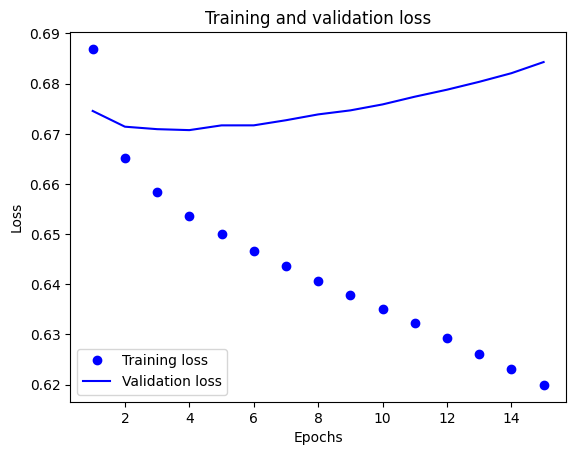

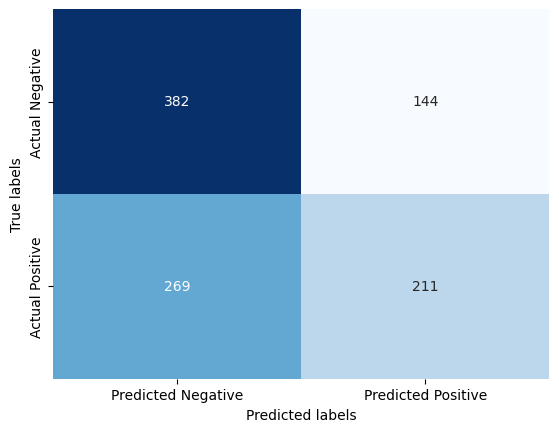


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       526
           1       0.59      0.44      0.51       480

    accuracy                           0.59      1006
   macro avg       0.59      0.58      0.58      1006
weighted avg       0.59      0.59      0.58      1006



In [54]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

Insights
Insights
- Logistic Regression performs better than XGB Classifier
- Most important attributes:

    - Encoded home coach
    - Encoded away coach
    - Encoded home qb
    - Encoded away qb
    - Home spread
    - Week
    - Divisional game
    - Game time
  
- The encoded values are of high importance. It makes sense, as they are directly interwined with the target value.

- We are very likely overfitting, as it can be seen in the Neural Network loss graph. This can probably be caused because of the high number of variables, adding a lot of dimensionality. We will tackle this issue by selecting only the most important variables.

In [55]:
te_homespread_df.columns

Index(['season', 'playoffs', 'week', 'gametime', 'neutral_venue', 'away_rest',
       'home_rest', 'away_moneyline', 'home_moneyline', 'home_spread',
       'total_line', 'div_game', 'temp', 'wind', 'home_cover_spread',
       'weekday_Other', 'weekday_Sunday', 'weekday_Thursday',
       'home_team_encoded', 'away_team_encoded', 'home_qb_encoded',
       'away_qb_encoded', 'home_coach_encoded', 'away_coach_encoded'],
      dtype='object')

### Feature Selection

In [56]:
te_homespread_df = te_homespread_df[['week', 'gametime', 'home_spread', 'div_game', 'home_cover_spread',
                                     'home_qb_encoded', 'away_qb_encoded', 'home_coach_encoded', 'away_coach_encoded']]
te_homespread_df.sample(5)

,week,gametime,home_spread,div_game,home_cover_spread,home_qb_encoded,away_qb_encoded,home_coach_encoded,away_coach_encoded
1188,11,13,-7,0,0,0.424887,0.484851,0.391909,0.492889
5711,9,16,1,1,0,0.431823,0.512108,0.372807,0.527769
247,17,13,-6,1,0,0.477433,0.557536,0.373326,0.543222
5776,14,13,-4,0,0,0.529435,0.515723,0.359641,0.487672
2836,13,20,3,0,1,0.547218,0.463920,0.470578,0.540808


In [57]:
# Train - 70%
# Validation - 15%
# Test - 15%

# Declare X and y
X = te_homespread_df.drop(columns=["home_cover_spread"])
y = te_homespread_df["home_cover_spread"]

# First, split into training (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(
    X, y, test_size=0.3,shuffle=True, random_state=42, stratify=y
)

# Then, split the remaining 30% into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, shuffle=True, random_state=42, stratify=y_remaining
)

# Print the shapes of train, validation, and test sets
print(f"X_train shape: {X_train.shape}")
print("-" * 25)
print(f"X_val shape: {X_val.shape}")
print("-" * 25)
print(f"X_test shape: {X_test.shape}")
print("-" * 25)
print(f"y_train shape: {y_train.shape}")
print("-" * 25)
print(f"y_val shape: {y_val.shape}")
print("-" * 25)
print(f"y_test shape: {y_test.shape}")

# Turn data into arrays
X_train_array = X_train.values
X_val_array = X_val.values
X_test_array = X_test.values

X_train shape: (4694, 8)
-------------------------
X_val shape: (1006, 8)
-------------------------
X_test shape: (1006, 8)
-------------------------
y_train shape: (4694,)
-------------------------
y_val shape: (1006,)
-------------------------
y_test shape: (1006,)


In [58]:
# Initialize the StandardScaler
scaler_homespread = StandardScaler()

# Fit and transform the numerical columns in the training set and test set
X_train_scaled = scaler_homespread.fit_transform(X_train_array)
X_val_scaled = scaler_homespread.fit_transform(X_val_array)
X_test_scaled = scaler_homespread.transform(X_test_array)

# Show sample of X_train
X_train_scaled[0]

array([-0.65563485, -0.74896341,  0.89474238, -0.77310122,  0.5545892 ,
       -0.0177822 , -0.37700961,  0.30403432])

In [59]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=15, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5192 - loss: 0.6979 - val_accuracy: 0.6103 - val_loss: 0.6561
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5869 - loss: 0.6711 - val_accuracy: 0.6054 - val_loss: 0.6562
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5873 - loss: 0.6670 - val_accuracy: 0.6064 - val_loss: 0.6576
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5959 - loss: 0.6645 - val_accuracy: 0.6123 - val_loss: 0.6590
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5954 - loss: 0.6626 - val_accuracy: 0.6093 - val_loss: 0.6599
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5979 - loss: 0.6610 - val_accuracy: 0.6074 - val_loss: 0.6608
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6045 - loss: 0.6598 - val_accuracy: 0.6054 - val_loss: 0.6614
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6066 - loss: 0.6587 - val_accuracy: 0.6054 - val_loss

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


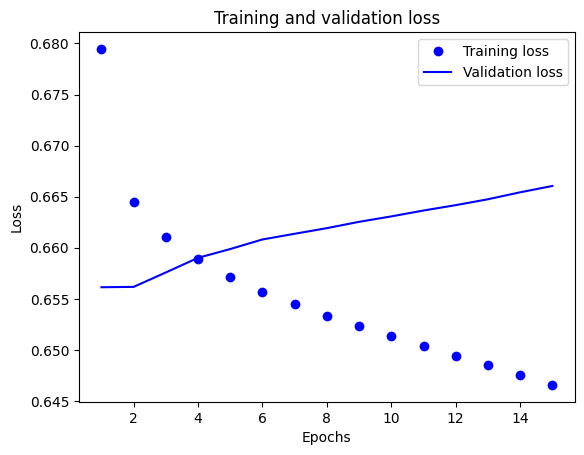

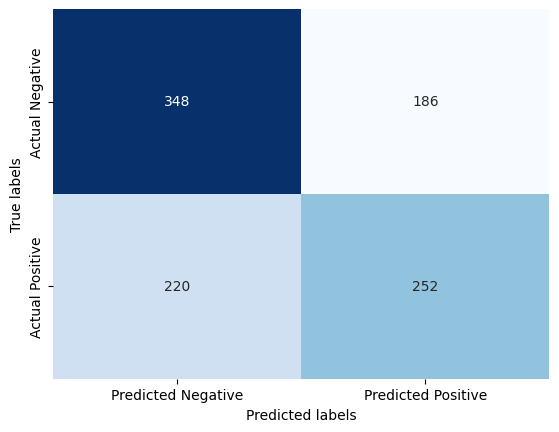


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       534
           1       0.58      0.53      0.55       472

    accuracy                           0.60      1006
   macro avg       0.59      0.59      0.59      1006
weighted avg       0.60      0.60      0.60      1006



In [60]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

- Our model accuracy improved by approximately 4%, which is a good indicator, but we are still clearly overfitting. Let us try to induce regularization to our neural network to try and improve results.

### Regularization

#### L1

In [61]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5321 - loss: 1.0039 - val_accuracy: 0.5915 - val_loss: 0.9291
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5866 - loss: 0.9218 - val_accuracy: 0.5994 - val_loss: 0.8726
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5972 - loss: 0.8686 - val_accuracy: 0.6054 - val_loss: 0.8316
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5936 - loss: 0.8297 - val_accuracy: 0.6074 - val_loss: 0.8033
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5933 - loss: 0.8027 - val_accuracy: 0.6143 - val_loss: 0.7806
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5965 - loss: 0.7809 - val_accuracy: 0.6113 - val_loss: 0.7611
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5927 - loss: 0.7624 - val_accuracy: 0.6103 - val_loss: 0.7442
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5919 - loss: 0.7465 - val_accuracy: 0.6093 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


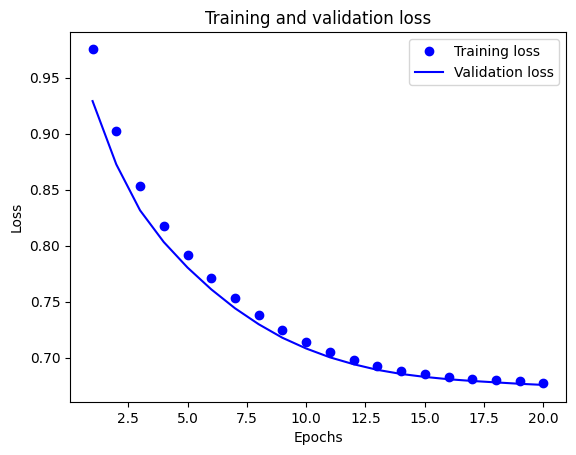

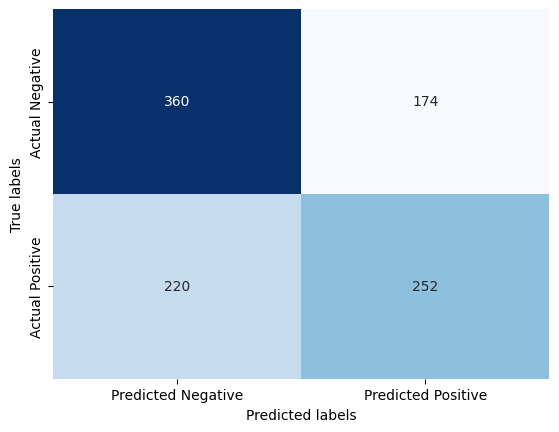

In [62]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = roc_auc_score(y_val, y_pred_probs)

#### L2

In [63]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5374 - loss: 0.7442 - val_accuracy: 0.6024 - val_loss: 0.7106
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5889 - loss: 0.7176 - val_accuracy: 0.6074 - val_loss: 0.7033
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5899 - loss: 0.7093 - val_accuracy: 0.6064 - val_loss: 0.6988
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5886 - loss: 0.7034 - val_accuracy: 0.6024 - val_loss: 0.6953
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5964 - loss: 0.6987 - val_accuracy: 0.5994 - val_loss: 0.6925
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5984 - loss: 0.6948 - val_accuracy: 0.6024 - val_loss: 0.6904
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5991 - loss: 0.6915 - val_accuracy: 0.6034 - val_loss: 0.6883
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6009 - loss: 0.6886 - val_accuracy: 0.6034 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


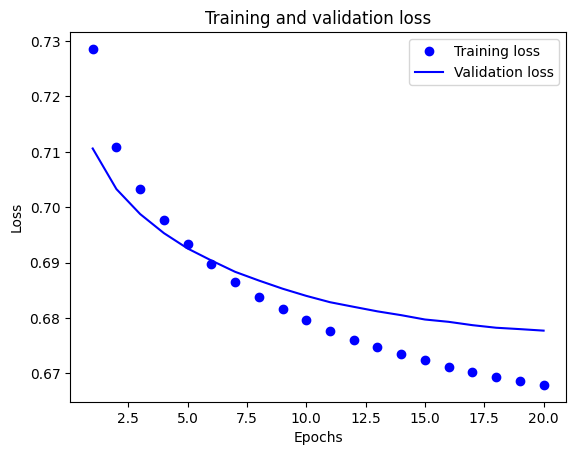

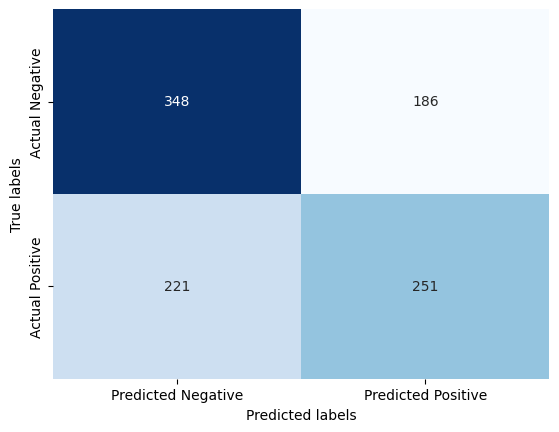

In [64]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)
roc_auc = roc_auc_score(y_val, y_pred_probs)

- L1 regularization works better than L2 regularization, as its loss is lower and accuracy is higher. Our model continues to improve, the validation curve is now heading in the right direction. We will now add Dropout layers and see what happens.

### Add Dropout Layers

In [65]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5270 - loss: 1.0109 - val_accuracy: 0.5974 - val_loss: 0.9309
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5789 - loss: 0.9235 - val_accuracy: 0.6064 - val_loss: 0.8671
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5806 - loss: 0.8666 - val_accuracy: 0.6113 - val_loss: 0.8191
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5901 - loss: 0.8159 - val_accuracy: 0.6153 - val_loss: 0.7861
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5940 - loss: 0.7871 - val_accuracy: 0.6143 - val_loss: 0.7627
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5878 - loss: 0.7675 - val_accuracy: 0.6183 - val_loss: 0.7441
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5886 - loss: 0.7504 - val_accuracy: 0.6223 - val_loss: 0.7303
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5933 - loss: 0.7368 - val_accuracy: 0.6163 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


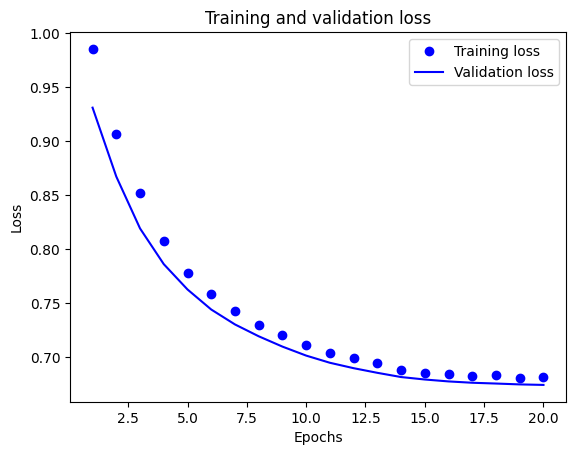

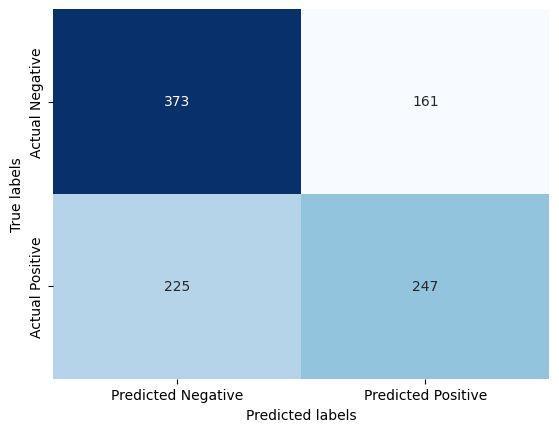


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       534
           1       0.61      0.52      0.56       472

    accuracy                           0.62      1006
   macro avg       0.61      0.61      0.61      1006
weighted avg       0.62      0.62      0.61      1006



In [66]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

### Batch Normalization

In [67]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5406 - loss: 1.1933 - val_accuracy: 0.5606 - val_loss: 1.0010
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5455 - loss: 1.0719 - val_accuracy: 0.5606 - val_loss: 0.9898
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5439 - loss: 1.0414 - val_accuracy: 0.5765 - val_loss: 0.9678
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5751 - loss: 0.9843 - val_accuracy: 0.5805 - val_loss: 0.9491
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5933 - loss: 0.9616 - val_accuracy: 0.5905 - val_loss: 0.9315
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5648 - loss: 0.9615 - val_accuracy: 0.6014 - val_loss: 0.9145
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5793 - loss: 0.9294 - val_accuracy: 0.6024 - val_loss: 0.9003
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5914 - loss: 0.9165 - val_accuracy: 0.6024 - val_loss:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


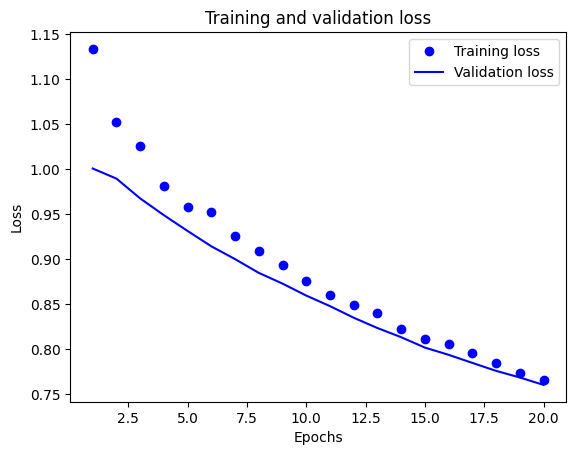

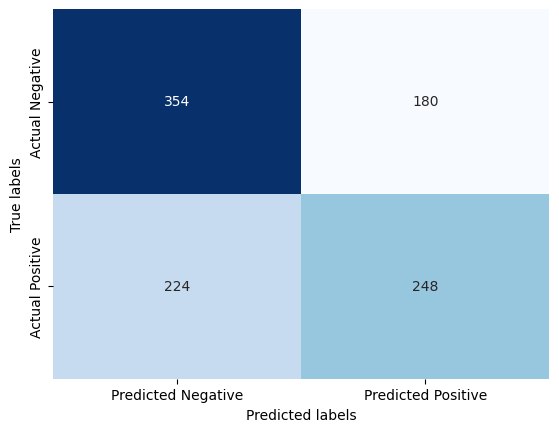


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.66      0.64       534
           1       0.58      0.53      0.55       472

    accuracy                           0.60      1006
   macro avg       0.60      0.59      0.59      1006
weighted avg       0.60      0.60      0.60      1006



In [68]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

### SMOTE

In [69]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Initialize SMOTE with the desired number of neighbors
smote = SMOTE(sampling_strategy='all', k_neighbors=3)  # You can change k_neighbors based on your data

# Apply SMOTE to generate synthetic data
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Display the new dataset
print("Original dataset size:", X_train_scaled.shape)
print("Resampled dataset size:", X_resampled.shape)

Original dataset size: (4694, 8)
Resampled dataset size: (4982, 8)


In [70]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_resampled.shape[1], ), kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=20, batch_size=256, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5167 - loss: 1.0243 - val_accuracy: 0.5706 - val_loss: 0.9831
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5576 - loss: 0.9845 - val_accuracy: 0.5875 - val_loss: 0.9509
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5749 - loss: 0.9547 - val_accuracy: 0.5934 - val_loss: 0.9251
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5818 - loss: 0.9295 - val_accuracy: 0.5944 - val_loss: 0.9017
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5948 - loss: 0.9006 - val_accuracy: 0.5954 - val_loss: 0.8798
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5781 - loss: 0.8839 - val_accuracy: 0.5934 - val_loss: 0.8590
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.8593 - val_accuracy: 0.5944 - val_loss: 0.8404
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5924 - loss: 0.8427 - val_accuracy: 0.5944 - val_loss

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


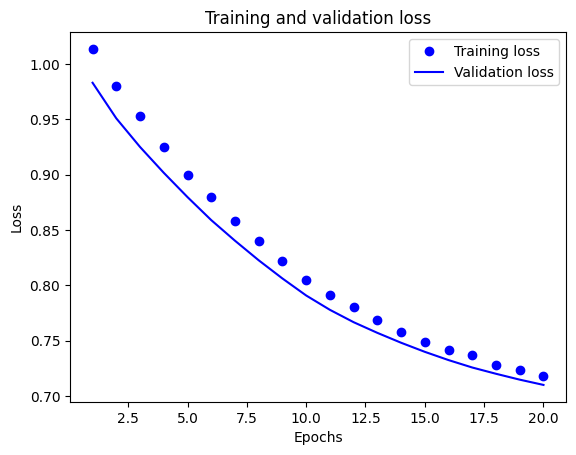

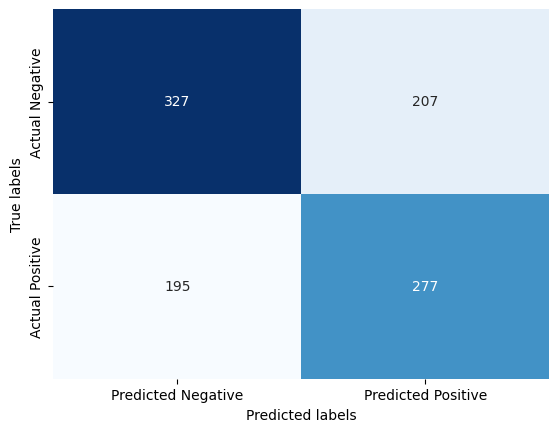


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       534
           1       0.57      0.59      0.58       472

    accuracy                           0.60      1006
   macro avg       0.60      0.60      0.60      1006
weighted avg       0.60      0.60      0.60      1006



In [71]:
# Make Predictions
y_pred_probs = model.predict(X_val_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

### Evaluate predictions on test set

In [107]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_51 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4770 - loss: 1.0522 - val_accuracy: 0.5974 - val_loss: 0.9513
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5761 - loss: 0.9476 - val_accuracy: 0.6113 - val_loss: 0.8939
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5970 - loss: 0.8949 - val_accuracy: 0.6123 - val_loss: 0.8520
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5836 - loss: 0.8573 - val_accuracy: 0.6123 - val_loss: 0.8231
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5972 - loss: 0.8262 - val_accuracy: 0.6153 - val_loss: 0.7976
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5864 - loss: 0.8013 - val_accuracy: 0.6064 - val_loss: 0.7770
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5940 - loss: 0.7815 - val_accuracy: 0.6054 - val_loss: 0.7588
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6060 - loss: 0.7621 - val_accuracy: 0.6133 - val_l

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


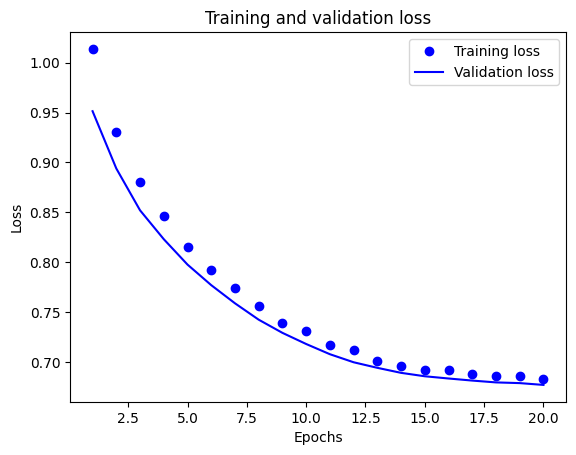

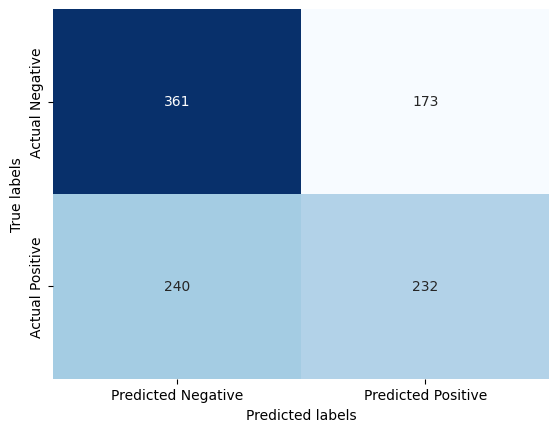


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       534
           1       0.57      0.49      0.53       472

    accuracy                           0.59      1006
   macro avg       0.59      0.58      0.58      1006
weighted avg       0.59      0.59      0.59      1006



In [109]:
# Make Predictions
y_pred_probs = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Model Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print()

# Show metrics
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

### Train model on all data

In [110]:
# Join all datasets
X = np.concatenate((X_train_scaled, X_val_scaled, X_test_scaled), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)
len(X), len(y)

(6706, 6706)

In [111]:
# Define the neural network model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1], ), kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(l1=0.001)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5502 - loss: 1.0029
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5810 - loss: 0.9067
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6025 - loss: 0.8425
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6027 - loss: 0.8006
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.7683
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5984 - loss: 0.7459
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5933 - loss: 0.7272
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6063 - loss: 0.7106
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6046 - loss: 0.7007
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5983 - loss: 0.6956
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6042 - loss: 0.6911
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

### Save Model

In [112]:
path = "/content/drive/MyDrive/NFLPred/Models/home_cover.h5"
joblib.dump(model, path)

['/content/drive/MyDrive/NFLPred/Models/home_cover.h5']